<h1>Logistic Regression From Scratch: Multi-class Classification</h1>


Linear Regression is for estimating continuous values, such as predicting house prices. However, Linear Regression falls short when the goal shifts to predicting the most likely class for a given data point. In such cases, <u>Logistic</u> Regression emerges as the preferred choice. Unlike Linear Regression, Logistic Regression assesses the probability of a data point belonging to a specific class, thus proving invaluable in classification tasks.

Linear Regression is for estimating continuous values, such as predicting house prices. However, Linear Regression falls short when the goal shifts to predicting the most likely class for a given data point. In such cases, <u>Logistic</u> Regression emerges as the preferred choice. Unlike Linear Regression, Logistic Regression assesses the probability of a data point belonging to a specific class in classification tasks.

Logistic Regression is a variation of Linear Regression, useful when the dependent variable <i>y</i> is categorical. Despite the name logistic <i>regression</i>, it is a <b>probabilistic classification</b> model. Logistic regression fits a special s-shaped curve by taking the linear regression and transforming the numeric estimate into a probability with the following function:

$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y}
$$

which produces values between 0 (as y approaches minus infinity $-\infty$) and 1 (as y approaches plus infinity $+\infty$). This now becomes a special kind of non-linear regression.

In the equation, <i>y</i> is the regression result (the sum of the variables weighted by the coefficients), <code>exp</code> is the exponential function, and $\theta(y)$ is the logistic function, also called a logistic curve. It is a common "S" shape (sigmoid curve).

In [1]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

<h2>Iris Dataset</h2>

<a href="https://archive.ics.uci.edu/ml/datasets/iris">The Iris Dataset</a> consists of 50 samples from each of the three species of Iris. In total, it has 150 records under five attributes and species.

Attributes Independent Variables:
<ul>
    <li>petal length</li>
    <li>petal width</li>
    <li>sepal length</li>
    <li>sepal width</li>
</ul>
Dependent Variables:
<ul>
    <li>Iris setosa</li>
    <li>Iris virginica</li>
    <li>Iris versicolor</li>
</ul>
<br>

Next, we load the dataset pre-built within the sklearn library. Preprocess the features and values, and then we can start using it. Afterward, we separate the dataset into training and testing parts randomly.

In [490]:
dataset = load_iris() # Load the dataset
x, y = dataset.data, dataset.target # Seperate x (independent variable) and y (dependent variable)

# Preprocess the x values by normalizing them:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
# Preprocess the y values by encoding them to one-hot vector:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Split the dataset to train and test sets:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024, shuffle=True)

train_x = tf.constant(train_x, dtype=tf.float32)
test_x = tf.constant(test_x, dtype=tf.float32)
train_y = tf.constant(train_y, dtype=tf.float32)
test_y = tf.constant(test_y, dtype=tf.float32)

<h2>Define Model Components</h2>

We start by defining the loss function. Since we want to solve a classification task, we need to define an appropriate loss function that can aid the model in providing valuable signal based on correct predicting the label class. Therefore, we are going to define and use cross-entropy loss function for multi-class classification as follows:

<!DOCTYPE html>
<html>
<body>
  <p>\[ \text{Cross-Entropy Loss} = - \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \cdot \log(p_{ij}) \]</p>
  <ul>
    <li>\( N \) is the number of samples in the batch.</li>
    <li>\( C \) is the number of classes.</li>
    <li>\( y_{ij} \) is the actual label (one-hot encoded) for sample \( i \) and class \( j \).</li>
    <li>\( p_{ij} \) is the predicted probability for sample \( i \) and class \( j \).</li>
  </ul>
  <p>This formula calculates the cross-entropy loss over the entire batch for multi-class classification tasks.</p>
</body>
</html>

<h3>Loss Function</h3>

In [360]:
def loss_function(predicted_y, actual_y):
    loss = tf.reduce_sum(actual_y * tf.math.log(tf.math.softmax(predicted_y)), axis=1)
    return -tf.reduce_mean(tf.cast(loss, dtype=tf.float32), axis=0)

Now, let's define the logistic regression model:

Logistic regression is typically thought of as a single equation:

ŷ = sigmoid(w * x + b)

We can have it broken into its three main components: 

-   a weight times features matrix multiplication operation, 
-   a summation of the weighted features and a bias term, 
-   and the application of a sigmoid function.

The function we are going to use is the <i>logistic function</i> $(\frac{1}{1+e^{-Wx}})$, which is fed the input data after applying weights and bias. In TensorFlow, this function is implemented as the <code>nn.sigmoid</code> function. Effectively, this fits the weighted input with bias into a 0-100 % curve, which is the probability function we want.

<h3>Logistic Regression Model</h3>

In [361]:
def logistic_regression(features, weights, bias):
    linear_transformation = tf.matmul(features, weights, name='linear_transformation') # Calculate the linear transformation
    with_bias = tf.add(linear_transformation, bias, name='add_bias') # Add the bias term
    output = tf.nn.sigmoid(with_bias, name='sigmoid_activation') # Apply the sigmoid activation function
    return output

<h3>Accuracy</h3>
We also want some additional operations to keep track of our model's efficiency over time. We can do this like so:

In [362]:
def compute_accuracy(predicted_y, actual_y):
    correct_prediction = tf.equal(tf.argmax(predicted_y, axis=1), tf.argmax(actual_y, axis=1))
    return tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

<h2>Training</h2>

We can't use <b>least-squares linear regression</b> here, so we should use Adam optimizer to reduce the loss through looping over the entire batch:

In [8]:
def run(learning_rate, total_epochs, interval_print=10):
    global accuracy_values, test_accuracy_values, loss_values, test_loss_values
    accuracy_values = []
    test_accuracy_values = []
    loss_values = []
    test_loss_values = []

    global weights, bias
    weights = tf.Variable(tf.random.normal((train_x.shape[-1], train_y.shape[-1]), mean=0, stddev=0.1), dtype=tf.float32)
    bias = tf.Variable(tf.random.normal((1, train_y.shape[-1]), mean=0, stddev=0.1), dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    for epoch in range(1, total_epochs + 1):
        with tf.GradientTape() as tape:
            pred = logistic_regression(train_x, weights, bias)
            loss = loss_function(pred, train_y)
        gradient = tape.gradient(loss, [weights, bias])
        optimizer.apply_gradients(zip(gradient, [weights, bias]))
    
        loss_values.append(loss)
        accuracy = compute_accuracy(pred, train_y)
        accuracy_values.append(accuracy)
        
        if epoch % interval_print == 0:
            test_pred = logistic_regression(test_x, weights, bias)
            test_loss = loss_function(test_pred, test_y)
    
            test_loss_values.append(test_loss)
            test_accuracy = compute_accuracy(test_pred, test_y)
            test_accuracy_values.append(test_accuracy)
            
            print(f'Epoch: {epoch:04d} || Train Loss: {loss:.3f}, Train Accuracy: {accuracy:.3f} || Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

In [9]:
run(learning_rate=0.01, total_epochs = 100)

Epoch: 0010 || Train Loss: 1.087, Train Accuracy: 0.350 || Test Loss: 1.089, Test Accuracy: 0.267
Epoch: 0020 || Train Loss: 1.069, Train Accuracy: 0.375 || Test Loss: 1.071, Test Accuracy: 0.400
Epoch: 0030 || Train Loss: 1.052, Train Accuracy: 0.650 || Test Loss: 1.051, Test Accuracy: 0.667
Epoch: 0040 || Train Loss: 1.035, Train Accuracy: 0.667 || Test Loss: 1.031, Test Accuracy: 0.667
Epoch: 0050 || Train Loss: 1.019, Train Accuracy: 0.667 || Test Loss: 1.012, Test Accuracy: 0.667
Epoch: 0060 || Train Loss: 1.003, Train Accuracy: 0.667 || Test Loss: 0.996, Test Accuracy: 0.667
Epoch: 0070 || Train Loss: 0.989, Train Accuracy: 0.667 || Test Loss: 0.981, Test Accuracy: 0.667
Epoch: 0080 || Train Loss: 0.975, Train Accuracy: 0.667 || Test Loss: 0.967, Test Accuracy: 0.667
Epoch: 0090 || Train Loss: 0.962, Train Accuracy: 0.667 || Test Loss: 0.954, Test Accuracy: 0.667
Epoch: 0100 || Train Loss: 0.950, Train Accuracy: 0.667 || Test Loss: 0.942, Test Accuracy: 0.667


Lets plot the loss values to see how it has changed during the training:

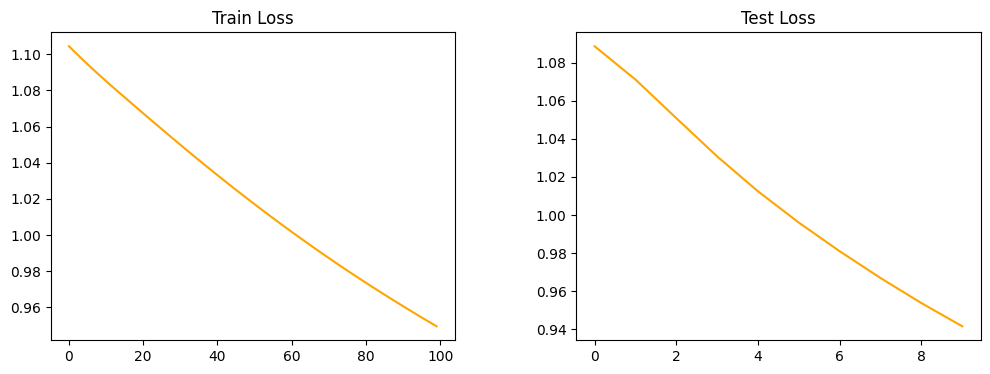

In [10]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot train loss
ax1.plot(loss_values, 'orange')
ax1.set_title('Train Loss')

# Plot test loss
ax2.plot(test_loss_values, 'orange')
ax2.set_title('Test Loss')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show plot
plt.show()

Weights Shape: (4, 3)
Bias Shape: (1, 3)

Gradient of the decision boundary: [0.8159533 0.9161738 1.1620489]
Intercept of the decision boundary: [-0.5267898   0.54091173  0.70345604]



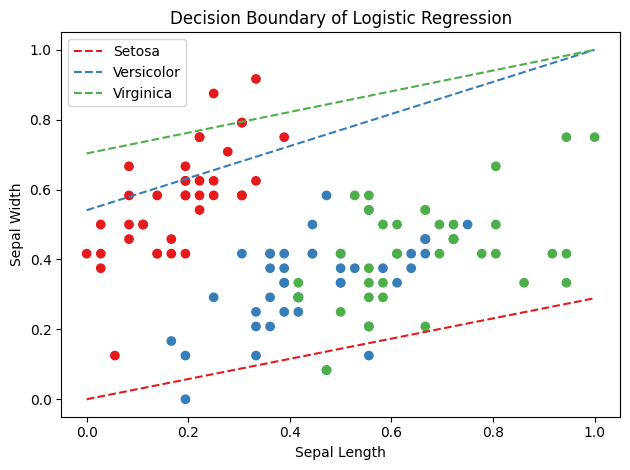

In [11]:
print(f'Weights Shape: {weights.shape}')
print(f'Bias Shape: {bias.shape}')
print()

coefficients = weights.numpy()
intercept = bias.numpy()

# Calculate the gradient of the decision boundary (coefficients)
decision_boundary_gradient = -coefficients[0, :] / coefficients[1, :]

# Calculate the intercept of the decision boundary
decision_boundary_intercept = -intercept[:, 0] / coefficients[1, :]
print("Gradient of the decision boundary:", decision_boundary_gradient)
print("Intercept of the decision boundary:", decision_boundary_intercept)
print()

# Scatter plot
selected_color_set = 'Set1'
colormap = plt.get_cmap(selected_color_set)

plt.scatter(train_x[:, 0], train_x[:, 1], c=encoder.inverse_transform(train_y).reshape(-1), cmap=colormap, norm=plt.Normalize(0, len(colormap.colors) - 1))

# Plot decision boundary for each class
for i in range(decision_boundary_gradient.shape[0]):
    x_values = np.array([0, 1])
    y_values = decision_boundary_gradient[i] * x_values + decision_boundary_intercept[i]
    y_values = np.clip(y_values, a_min=0, a_max=1)
    plt.plot(x_values, y_values, label=f'{dataset.target_names[i].capitalize()}', lw=1.5, ls='--', color=colormap(i))

# Customize plot
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Decision Boundary of Logistic Regression")
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

<h1>Logistic Regression: One-vs-All</h1>

In [516]:
def loss_function(pred, actual):
    # probability = tf.math.softmax(pred, axis=1)
    # probability = tf.nn.sigmoid(pred)
    probability = pred
    loss = - tf.reduce_mean(actual * tf.math.log(probability)
                            + (1 - actual) * tf.math.log(1 - probability))
    return loss

In [531]:
def compute_accuracy(predicted_y, actual_y):
    # print(predicted_y, '\n', actual_y)
    # correct_prediction = tf.equal(tf.argmax(predicted_y, axis=1), tf.argmax(actual_y, axis=1))
    predicted_y = tf.where(predicted_y > 0.5, 1.0, 0.0)
    correct_prediction = tf.equal(predicted_y, actual_y)
    return tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

In [532]:
def run(learning_rate, total_epochs, train_y, interval_print=10):
    global accuracy_values, test_accuracy_values, loss_values, test_loss_values
    accuracy_values = []
    test_accuracy_values = []
    loss_values = []
    test_loss_values = []

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    weights = tf.Variable(tf.random.normal((train_x.shape[-1], 1), mean=0.5, stddev=0.5), dtype=tf.float32)
    bias = tf.Variable(tf.random.normal((1, 1), mean=0.5, stddev=0.5), dtype=tf.float32)
    
    for epoch in range(1, total_epochs + 1):
        with tf.GradientTape() as tape:
            pred = logistic_regression(train_x, weights, bias)
            loss = loss_function(pred, train_y)
        gradient = tape.gradient(loss, [weights, bias])
        optimizer.apply_gradients(zip(gradient, [weights, bias]))
    
        loss_values.append(loss)
        accuracy = compute_accuracy(pred, train_y)
        accuracy_values.append(accuracy)
        
        if epoch % interval_print == 0:
            # test_pred = logistic_regression(test_x, weights, bias)
            # test_loss = loss_function(test_pred, test_y)
    
            # test_loss_values.append(test_loss)
            # test_accuracy = compute_accuracy(test_pred, test_y)
            # test_accuracy_values.append(test_accuracy)
            
            # print(f'Epoch: {epoch:04d} || Train Loss: {loss:.3f}, Train Accuracy: {accuracy:.3f} || Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')
            print(f'Epoch: {epoch:04d} || Train Loss: {loss:.3f}, Train Accuracy: {accuracy:.3f}')

    return weights, bias

In [533]:
learning_rate = 0.9
total_epochs = 100

train_y_2 = train_y.numpy()[:, 1:3]
train_y_2[:, -1] = 0
train_y_2 = np.max(train_y_2, axis=1).reshape(-1, 1)
train_y_2 = tf.constant(train_y_2, dtype=tf.float32)

classifier_2 = run(learning_rate, total_epochs, train_y_2)

Epoch: 0010 || Train Loss: 0.575, Train Accuracy: 0.611
Epoch: 0020 || Train Loss: 0.555, Train Accuracy: 0.651
Epoch: 0030 || Train Loss: 0.523, Train Accuracy: 0.698
Epoch: 0040 || Train Loss: 0.507, Train Accuracy: 0.732
Epoch: 0050 || Train Loss: 0.499, Train Accuracy: 0.725
Epoch: 0060 || Train Loss: 0.495, Train Accuracy: 0.718
Epoch: 0070 || Train Loss: 0.493, Train Accuracy: 0.725
Epoch: 0080 || Train Loss: 0.492, Train Accuracy: 0.732
Epoch: 0090 || Train Loss: 0.491, Train Accuracy: 0.725
Epoch: 0100 || Train Loss: 0.490, Train Accuracy: 0.732


In [494]:
learning_rate = 0.5
total_epochs = 200


# label 1
train_y_1 = train_y.numpy()[:, 0:2]
train_y_1[:, -1] = 0
train_y_1 = np.max(train_y_1, axis=1).reshape(-1, 1)
train_y_1 = tf.constant(train_y_1, dtype=tf.float32)

classifier_1 = run(learning_rate, total_epochs, train_y_1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
print()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~

# label 2
train_y_2 = train_y.numpy()[:, 1:3]
train_y_2[:, -1] = 0
train_y_2 = np.max(train_y_2, axis=1).reshape(-1, 1)
train_y_2 = tf.constant(train_y_2, dtype=tf.float32)

classifier_2 = run(learning_rate, total_epochs, train_y_2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~
print()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~

# label 3
train_y_3 = train_y.numpy()[:, 1:3]
train_y_3[:, 0] = 0
train_y_3 = np.max(train_y_3, axis=1).reshape(-1, 1)
train_y_3 = tf.constant(train_y_3, dtype=tf.float32)

classifier_3 = run(learning_rate, total_epochs, train_y_3)

Epoch: 0010 || Train Loss: 0.178, Train Accuracy: 1.000
Epoch: 0020 || Train Loss: 0.060, Train Accuracy: 1.000
Epoch: 0030 || Train Loss: 0.022, Train Accuracy: 1.000
Epoch: 0040 || Train Loss: 0.016, Train Accuracy: 1.000
Epoch: 0050 || Train Loss: 0.012, Train Accuracy: 1.000
Epoch: 0060 || Train Loss: 0.010, Train Accuracy: 1.000
Epoch: 0070 || Train Loss: 0.009, Train Accuracy: 1.000
Epoch: 0080 || Train Loss: 0.008, Train Accuracy: 1.000
Epoch: 0090 || Train Loss: 0.007, Train Accuracy: 1.000
Epoch: 0100 || Train Loss: 0.007, Train Accuracy: 1.000
Epoch: 0110 || Train Loss: 0.006, Train Accuracy: 1.000
Epoch: 0120 || Train Loss: 0.006, Train Accuracy: 1.000
Epoch: 0130 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0140 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0150 || Train Loss: 0.005, Train Accuracy: 1.000
Epoch: 0160 || Train Loss: 0.004, Train Accuracy: 1.000
Epoch: 0170 || Train Loss: 0.004, Train Accuracy: 1.000
Epoch: 0180 || Train Loss: 0.004, Train Accuracy

In [495]:
# Label 1
weights = classifier_1[0]
bias = classifier_1[1]

label_1 = logistic_regression(test_x, weights, bias)
label_1 = tf.where(label_1 > 0.5, 1.0, 0.0)

In [496]:
# Label 2
weights = classifier_2[0]
bias = classifier_2[1]

label_2 = logistic_regression(test_x, weights, bias)
label_2 = tf.where(label_2 > 0.5, 1.0, 0.0)

In [497]:
# Label 3
weights = classifier_3[0]
bias = classifier_3[1]

label_3 = logistic_regression(test_x, weights, bias)
label_3 = tf.where(label_3 > 0.5, 1.0, 0.0)

In [498]:
zeroes = np.zeros(shape=(len(test_y), test_y.shape[-1]), dtype=np.uint16)

zeroes[:,0] = label_1.numpy().reshape(-1)
zeroes[:,1] = label_2.numpy().reshape(-1)
zeroes[:,2] = label_3.numpy().reshape(-1)

row_equality = np.all(zeroes == test_y.numpy().astype(np.uint16), axis=1)
num_corrects  = np.mean(row_equality)

print(f'Test Accuracy: {num_corrects:.3f}')

Test Accuracy: 1.000


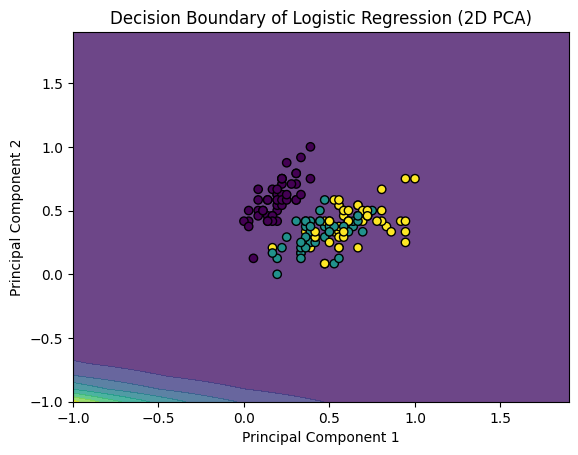

In [576]:
# Plot decision boundary

xx, yy = np.meshgrid(np.arange(-1, 2, 0.1),
                     np.arange(-1, 2, 0.1))

z = logistic_regression(tf.cast(np.c_[xx.ravel(), yy.ravel()], dtype=tf.float32), (classifier_3[0])[0:2, :], bias) 
z = z.numpy().reshape(xx.shape)

plt.contourf(xx, yy, z, alpha=0.8)
plt.scatter(train_x.numpy()[:, 0], train_x.numpy()[:, 1], c=encoder.inverse_transform(train_y).reshape(-1), edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of Logistic Regression (2D PCA)')
plt.show()

Gradient of the decision boundary: [0.69427234]
Intercept of the decision boundary: [-0.3734978]



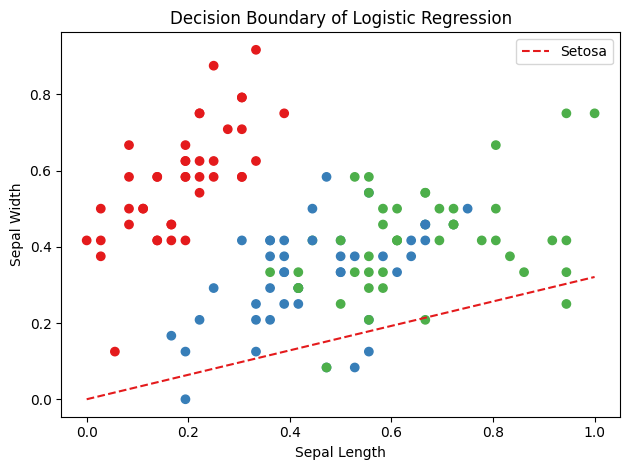

In [405]:
coefficients = classifier_1[0].numpy()
intercept = classifier_1[1].numpy()

# Calculate the gradient of the decision boundary (coefficients)
decision_boundary_gradient = -coefficients[0, :] / coefficients[1, :]

# Calculate the intercept of the decision boundary
decision_boundary_intercept = -intercept[:, 0] / coefficients[1, :]
# decision_boundary_gradient = coefficients[0]
# decision_boundary_intercept = intercept
print("Gradient of the decision boundary:", decision_boundary_gradient)
print("Intercept of the decision boundary:", decision_boundary_intercept)
print()

# Scatter plot
selected_color_set = 'Set1'
colormap = plt.get_cmap(selected_color_set)

plt.scatter(train_x[:, 0], train_x[:, 1], c=encoder.inverse_transform(train_y).reshape(-1), cmap=colormap, norm=plt.Normalize(0, len(colormap.colors) - 1))

# Plot decision boundary for each class
for i in range(len(decision_boundary_gradient)):
    x_values = np.array([0, 1])
    y_values = decision_boundary_gradient[i] * x_values + decision_boundary_intercept[i]
    y_values = np.clip(y_values, a_min=0, a_max=1)
    plt.plot(x_values, y_values, label=f'{dataset.target_names[i].capitalize()}', lw=1.5, ls='--', color=colormap(i))

# Customize plot
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Decision Boundary of Logistic Regression")
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [489]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data  # Use only the first two features
Y = iris.target

# Create and train the logistic regression classifier
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

# Predict classes on the training data
Y_pred = logreg.predict(X)

# Calculate accuracy
accuracy = accuracy_score(Y, Y_pred)
print("Accuracy:", accuracy)

# Plot decision boundary and training points
# _, ax = plt.subplots(figsize=(4, 3))
# DecisionBoundaryDisplay.from_estimator(
#     logreg,
#     X,
#     cmap=plt.cm.Paired,
#     ax=ax,
#     response_method="predict",
#     plot_method="pcolormesh",
#     shading="auto",
#     xlabel="Sepal length",
#     ylabel="Sepal width",
#     eps=0.5,
# )
# plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)
# plt.xticks(())
# plt.yticks(())
# plt.show()


Accuracy: 0.9866666666666667
